In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from src.nflow_utils import *


In [2]:
from nflows import transforms, distributions, flows
import torch
import torch.nn.functional as F
from nflows.distributions import uniform


In [3]:
#os.environ["CUDA_VISIBLE_DEVICES"]='2'


CUDA = True
device = torch.device("cuda:0" if CUDA else "cpu")

kwargs = {'num_workers': 4, 'pin_memory': True} if CUDA else {}
kwargs = {}


In [4]:
CRdata=np.random.normal(scale=1,loc=0,size=100000)
SRdata=np.concatenate((np.random.normal(scale=1,loc=0,size=50000),np.random.normal(scale=1,loc=3,size=50000)))
np.random.shuffle(SRdata)

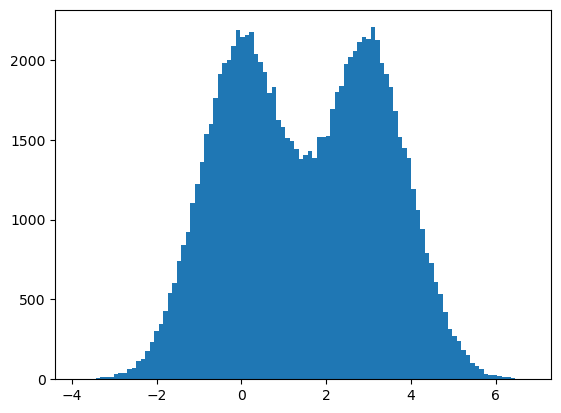

In [5]:
_=plt.hist(SRdata,bins=100)

In [6]:
traintensor = torch.from_numpy(SRdata[:90000].astype('float32').reshape((-1,1)))
#traindataset = torch.utils.data.TensorDataset(traintensor)

valtensor = torch.from_numpy(SRdata[90000:].astype('float32').reshape((-1,1)))
#valdataset = torch.utils.data.TensorDataset(valtensor)

In [7]:
len(SRdata)

100000

In [8]:
# Use the standard pytorch DataLoader
batch_size = 256
#batch_size = 256
trainloader = torch.utils.data.DataLoader(traintensor, batch_size=batch_size, shuffle=True)


In [9]:
test_batch_size=batch_size*5
valloader = torch.utils.data.DataLoader(valtensor, batch_size=test_batch_size, shuffle=False)


In [10]:
model=define_model(nfeatures=1,nhidden=2,hidden_size=20,embedding=None,dropout=0,nembedding=0)


In [11]:
# train
valloss_list=[]
optimizer = torch.optim.Adam(model.parameters(),lr=1e-4) #,lr=1e-4)#, lr=1e-4)

for epoch in range(2):
    print('\n Epoch: {}'.format(epoch))
    train(model,optimizer,trainloader,noise_data=0.,noise_context=0.0)
    valloss=val(model,valloader)
    print('epoch '+str(epoch)+' val loss: ',valloss)
#    torch.save(model.state_dict(),"babydataset_fLDeltaf0.01_epoch_"+str(epoch)+"_Model.par")
    valloss_list.append(valloss)
    
    

 




 Epoch: 0
epoch 0 val loss:  1.956383203125

 Epoch: 1
epoch 1 val loss:  1.9546015625

 Epoch: 2
epoch 2 val loss:  1.9536119140625

 Epoch: 3
epoch 3 val loss:  1.954163671875

 Epoch: 4
epoch 4 val loss:  1.9559248046875

 Epoch: 5
epoch 5 val loss:  1.953825390625

 Epoch: 6
epoch 6 val loss:  1.9536728515625

 Epoch: 7
epoch 7 val loss:  1.9539892578125

 Epoch: 8
epoch 8 val loss:  1.9540080078125

 Epoch: 9
epoch 9 val loss:  1.9547755859375

 Epoch: 10
epoch 10 val loss:  1.9540123046875

 Epoch: 11
epoch 11 val loss:  1.954619140625

 Epoch: 12
epoch 12 val loss:  1.9531015625

 Epoch: 13
epoch 13 val loss:  1.9544060546875

 Epoch: 14
epoch 14 val loss:  1.9540078125

 Epoch: 15
epoch 15 val loss:  1.9541884765625

 Epoch: 16
epoch 16 val loss:  1.95457265625

 Epoch: 17
epoch 17 val loss:  1.953153125

 Epoch: 18
epoch 18 val loss:  1.95331796875

 Epoch: 19
epoch 19 val loss:  1.953458203125

 Epoch: 20
epoch 20 val loss:  1.953416015625

 Epoch: 21
epoch 21 val loss:  1.9

KeyboardInterrupt: 

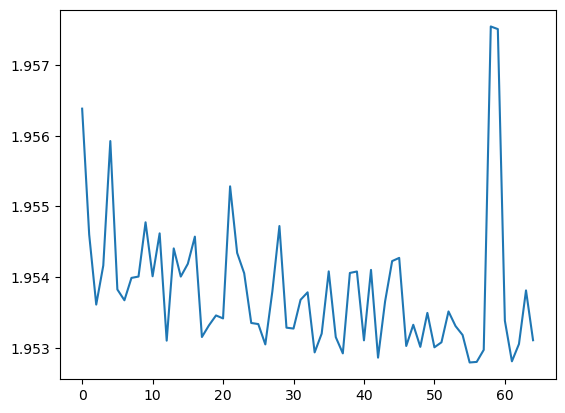

In [19]:
plt.plot(valloss_list)
plt.show()

In [14]:
model.eval()
with torch.no_grad():
    samples=model.sample(50000)
samples=samples.cpu().detach().numpy().reshape((-1))

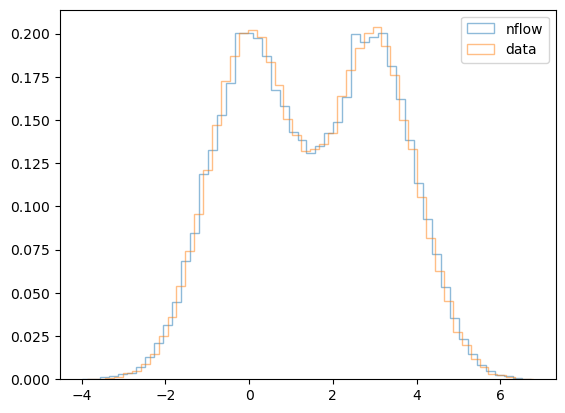

In [17]:
_=plt.hist(samples,bins=50, density=True, alpha=0.5, histtype='step', label='nflow')
_=plt.hist(SRdata,bins=50, density=True, alpha=0.5, histtype='step', label='data')
plt.legend(loc='upper right')
plt.show()